In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_colwidth', 200)

# Import Data

In [2]:
# 'Biological Data' sheet is where most info is
# 'Site Measurement Data' may also be useful

df_gns = pd.read_excel(r'.\raw_data\GNS Efish_2006-2020_For DM App.xlsx', sheet_name='Biological Data')
df_gns.columns = [x.strip().replace(' ', '_').upper() for x in df_gns.columns]

df_mar = pd.read_excel(r'.\raw_data\Margaree Efish_1957-2020_For DM App.xlsx', sheet_name='Biological Data')
df_mar.columns = [x.strip().replace(' ', '_').upper() for x in df_mar.columns]
df_mar['FORK_LENGTH'] = (pd.to_numeric(df_mar.FORK_LENGTH, errors='coerce') // 1).astype('Int64')

In [3]:
df_gns.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,12895.000,NaN,NaN,NaN,6448.000,3722.610,1.000,3224.500,6448.000,9671.500,12895.000
YEAR,12859.000,NaN,NaN,NaN,2013.612,4.303,2006.000,2010.000,2014.000,2017.000,2020.000
SITE,12859.000,32.000,4.000,2420.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RIVER_NAME,12859,16,River Philip,4114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SWEEP_NUMBER,12859.000,NaN,NaN,NaN,0.500,0.000,0.500,0.500,0.500,0.500,0.500
SPECIES,12855.000,20.000,1731.000,10597.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN,9964,2,W,9962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FISH_STATUS,12859,6,RS,12616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FORK_LENGTH,12776.000,NaN,NaN,NaN,66.187,21.397,13.500,53.000,59.000,75.000,552.000
TOTAL_LENGTH,5.000,NaN,NaN,NaN,333.200,183.261,44.000,325.000,325.000,442.000,530.000


In [4]:
df_mar.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,44472.000,NaN,NaN,NaN,22236.500,12838.105,1.000,11118.750,22236.500,33354.250,44472.000
YEAR,44472.000,NaN,NaN,NaN,1994.686,16.001,1957.000,1986.000,1999.000,2005.000,2020.000
SITE,44472.000,115.000,51.000,5404.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CGNDB,7941,10,Margaree,2727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SWEEP_NUMBER,41612.000,11.000,0.500,16974.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SPECIES_ITIS_CODE,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SPECIES,44472.000,23.000,1731.000,36774.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN,44472,3,W,43370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FISH_STATUS,41124,7,RS,36910,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FORK_LENGTH,35439.000,205.000,53.000,658.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# What are the differences between the two files?

In [5]:
# missing from gns
[x for x in df_mar.columns if x not in df_gns.columns]

['CGNDB', 'SPECIES_ITIS_CODE', 'FORK_LENGTH_INTERVAL_WIDTH']

In [7]:
df_mar.CGNDB.value_counts(dropna=False)

NaN         36531
Margaree     2727
CAMNO        1011
CBBWL         874
CATHP         668
CAWKZ         498
CBJVR         470
CACZB         443
CANHO         428
CARKU         427
CBPVG         395
Name: CGNDB, dtype: int64

In [10]:
# this is not a useful column
df_mar.SPECIES_ITIS_CODE.value_counts(dropna=False)

NaN    44472
Name: SPECIES_ITIS_CODE, dtype: int64

In [11]:
# this incomplete and redundant
df_mar.FORK_LENGTH_INTERVAL_WIDTH.value_counts(dropna=False)

NaN         40835
1            3521
81-85          11
96-100         10
86-90           9
71-75           8
91-95           8
76-80           8
101-105         8
106-110         7
66-70           7
56-60           4
116-120         4
111-115         4
136-140         3
41-45           3
61-65           3
126-130         3
31-35           2
51-55           2
26-30           2
121-125         2
36-40           2
131-135         2
1221-125        1
146-150         1
46-50           1
151-155         1
Name: FORK_LENGTH_INTERVAL_WIDTH, dtype: int64

Null Data: 9073
Non-Null Data: 35399


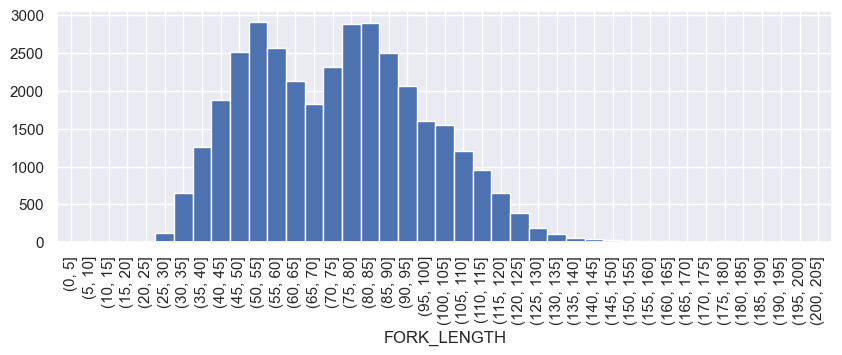

In [54]:
# way more information in fork_length
print('Null Data:', df_mar.FORK_LENGTH.isnull().sum())
print('Non-Null Data:', df_mar.FORK_LENGTH.notnull().sum())
df_mar.FORK_LENGTH.groupby(pd.cut(df_mar.FORK_LENGTH, [x*5 for x in range(42)])).count().plot(kind='bar', width=1, figsize=(10,3));

In [6]:
# missing from mar
[x for x in df_gns.columns if x not in df_mar.columns]

['RIVER_NAME']

In [9]:
df_gns.RIVER_NAME.value_counts(dropna=False)

River Philip              4114
West River Antigonish     3515
East River Pictou         2872
West River Pictou          562
Mabou                      462
Wallace                    201
Barney River               169
Wallace River              158
River John                 157
Wallace River              154
Barneys River              126
Barneys                    125
Barney's River             113
Mabou River                 83
NaN                         36
North East Mabou            33
River John East Branch      15
Name: RIVER_NAME, dtype: int64